In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from modAL.models import ActiveLearner, Committee
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
xs = np.random.uniform(low=0.0, high=500.0, size=500)
ys = np.random.uniform(low=0.0, high=500.0, size=500)

In [3]:
f1 = lambda x : 10000 / x
df1 = pd.DataFrame({'x' : xs, 'y' : ys})
df1['class'] = np.where(df1['y'] > f1(df1['x']), 1, 0)

f2 = lambda x : 200 * np.sin(0.05*x) + 250
df2 = pd.DataFrame({'x' : xs, 'y' : ys})
df2['class'] = np.where(df2['y'] > f2(df2['x']), 1, 0)

f3 = lambda x : np.power(x - 250, 2)/150 + 20
df3 = pd.DataFrame({'x' : xs, 'y' : ys})
df3['class'] = np.where(df3['y'] > f3(df3['x']), 1, 0)

f4 = lambda x, y: np.power(x - 250, 2) + np.power(y - 250, 2) <= np.power(105, 2)
df4 = pd.DataFrame({'x' : xs, 'y' : ys})
df4['class'] = np.where(f4(df4['x'], df4['y']), 1, 0)

datasets = [df1, df2, df3, df4]

In [4]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx.reshape(1,), X_pool[query_idx].reshape(1, -1)

In [5]:
def benchmark(learner, X_train, X_test, y_train, y_test, n_queries=100):
    
    scores = []
    
    iterations = []

    for i in range(n_queries):

        query_index, query_instance = learner.query(X_train)

        # Teach our ActiveLearner model the record it has requested.
        X, y = X_train[query_index].reshape(1, -1), y_train[query_index].reshape(1, )
        learner.teach(X=X, y=y)

        # Remove the queried instance from the unlabeled pool.
        X_train, y_train = np.delete(X_train, query_index, axis=0), np.delete(y_train, query_index)
        
        if (i+1) % 10 == 0:

            # Calculate and report our model's accuracy.
            model_accuracy = learner.score(X_test, y_test)

            scores.append(model_accuracy)
            iterations.append(i+1)
        
    return iterations, scores

In [6]:
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling
from modAL.disagreement import max_disagreement_sampling, consensus_entropy_sampling, vote_entropy_sampling
from modAL.expected_error import expected_error_reduction

In [7]:
committee_strats = [max_disagreement_sampling, consensus_entropy_sampling, vote_entropy_sampling]

In [8]:
ds_names = ['Synthetic dataset 1', 'Synthetic dataset 2', 'Synthetic dataset 3', 'Synthetic dataset 4']

In [9]:
def run_experiment(query_strategies, qs_names, repeat=5):
    
    col_scores = []
    col_iterations = []
    col_dataset = []
    col_strategy = []
    
    for _ in range(repeat):
        
        j = 0

        for df in datasets:

            X = df[['x', 'y']].to_numpy()
            y = df[['class']].to_numpy()


            X_train, X_test, y_train, y_test = train_test_split(X, y)

            for i in range(len(query_strategies)):
                if query_strategies[i] in committee_strats:
                    learner1 = ActiveLearner(
                    estimator=RandomForestClassifier(),
                    query_strategy=query_strategies[i]
                    )
                    learner2 = ActiveLearner(
                            estimator=RandomForestClassifier(),
                            query_strategy=query_strategies[i]
                    )
                    learner = Committee(learner_list=[learner1, learner2])
                else:
                    learner = ActiveLearner(
                    estimator=RandomForestClassifier(),
                    query_strategy=query_strategies[i]
                    )

                iterations, scores = benchmark(learner, X_train, X_test, y_train, y_test)

                col_scores.append(scores)
                col_iterations.append(iterations)
                col_dataset.append([ds_names[j]] * len(iterations))
                col_strategy.append([qs_names[i]] * len(iterations))


            j += 1
            
    return col_iterations, col_scores, col_dataset, col_strategy


# Experiment 1: Uncertainty measures

In [10]:
query_strategies = [uncertainty_sampling, entropy_sampling, margin_sampling, random_sampling]
qs_names = ['Uncertainty', 'Entropy', 'Margin', 'Random']

col_iteration, col_score, col_dataset, col_strategy = run_experiment(query_strategies, qs_names)

In [11]:
df = pd.DataFrame({
    'Iteration' : np.array(col_iteration).flatten(), 
    'Score' : np.array(col_score).flatten(),
    'Dataset' : np.array(col_dataset).flatten(),
    'Strategy' : np.array(col_strategy).flatten()
})

,Iteration,Score,Dataset,Strategy
0,10,0.872,Synthetic dataset 1,Uncertainty
1,20,0.880,Synthetic dataset 1,Uncertainty
2,30,0.848,Synthetic dataset 1,Uncertainty
3,40,0.968,Synthetic dataset 1,Uncertainty
4,50,0.984,Synthetic dataset 1,Uncertainty
...,...,...,...,...
795,60,0.960,Synthetic dataset 4,Random
796,70,0.960,Synthetic dataset 4,Random
797,80,0.936,Synthetic dataset 4,Random
798,90,0.944,Synthetic dataset 4,Random


In [12]:
import seaborn as sns

In [13]:
plt.rcParams["figure.figsize"] = (10,7.5)

In [31]:
def plot_exp(df):
    err_kws = {'capsize' : 3, 'capthick' : 1, 'elinewidth' : 1}

    sns.set_style('darkgrid')
    sns.relplot(
        data=df, 
        x='Iteration', 
        kind='line',
        y='Score',
        err_style='bars',
        err_kws=err_kws,
        markers=True,
        col='Dataset', 
        col_wrap=2, 
        style='Strategy',
        hue='Strategy', 
        markersize=7.5,
        facet_kws={'sharey': False}
    )
    plt.show()

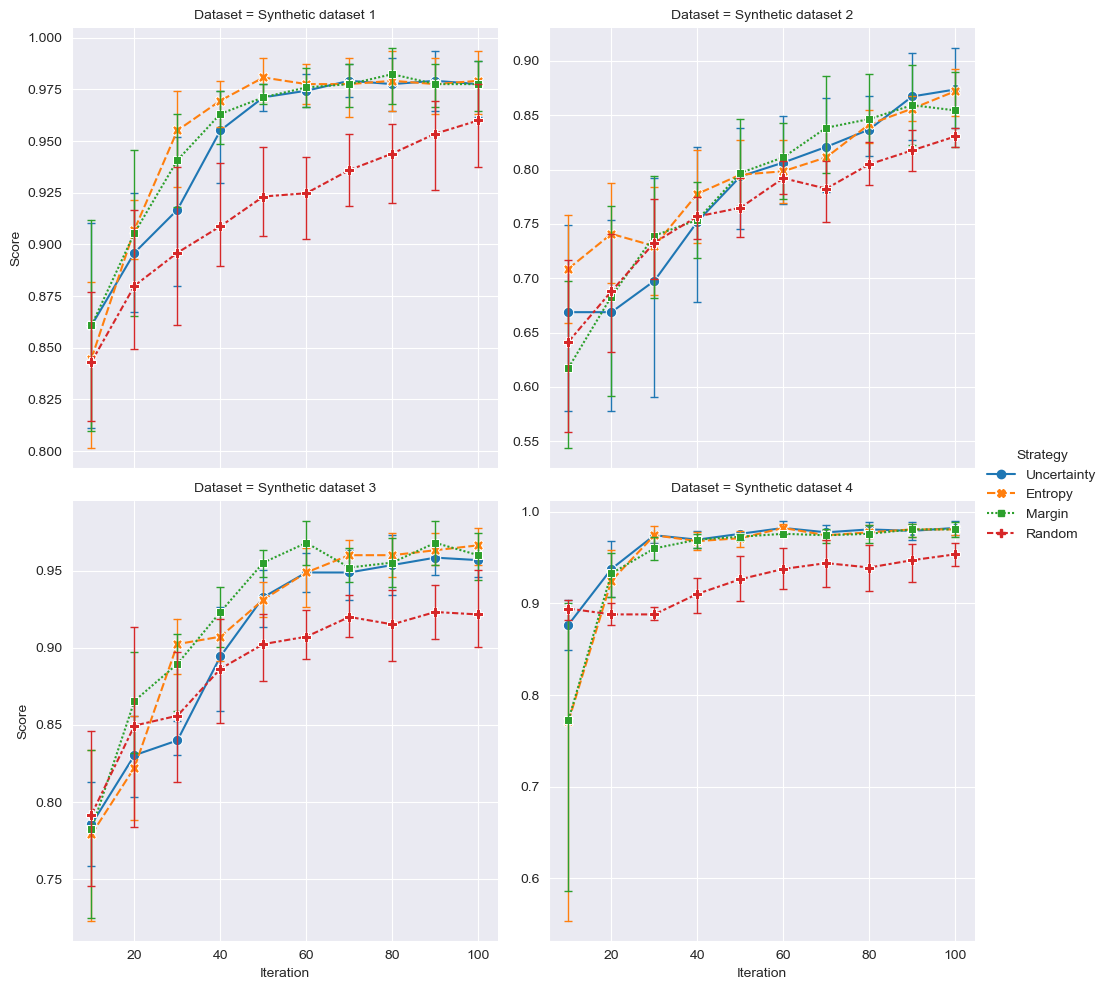

In [32]:
plot_exp(df)

# Experiment 2: Committee strategies

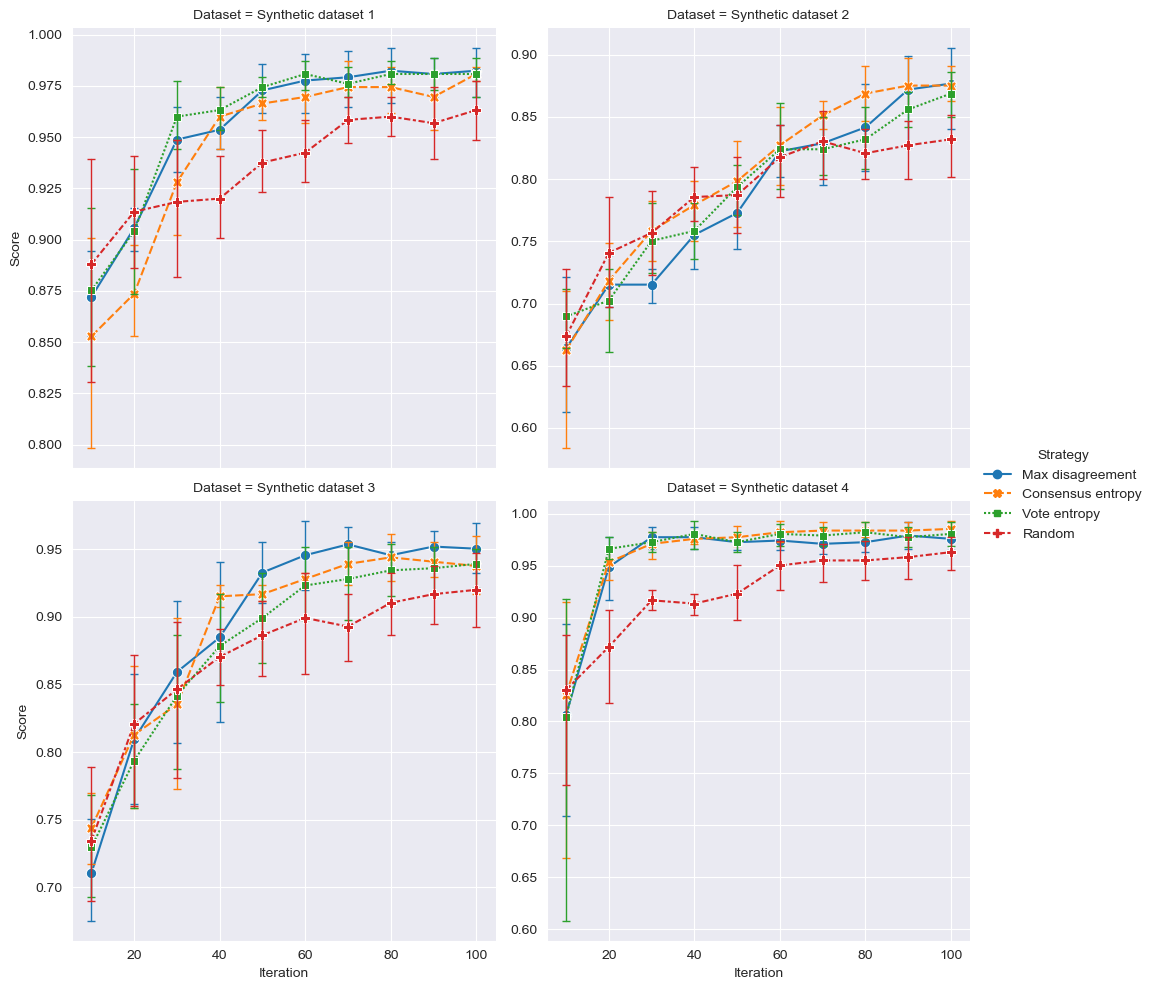

In [33]:
query_strategies = [
    max_disagreement_sampling, 
    consensus_entropy_sampling, 
    vote_entropy_sampling,
    random_sampling
]

qs_names = [
    'Max disagreement', 
    'Consensus entropy', 
    'Vote entropy',
    'Random'
]

col_iteration, col_score, col_dataset, col_strategy = run_experiment(query_strategies, qs_names)

df = pd.DataFrame({
    'Iteration' : np.array(col_iteration).flatten(), 
    'Score' : np.array(col_score).flatten(),
    'Dataset' : np.array(col_dataset).flatten(),
    'Strategy' : np.array(col_strategy).flatten()
})

plot_exp(df)

# Experiment 3: Expected error reduction

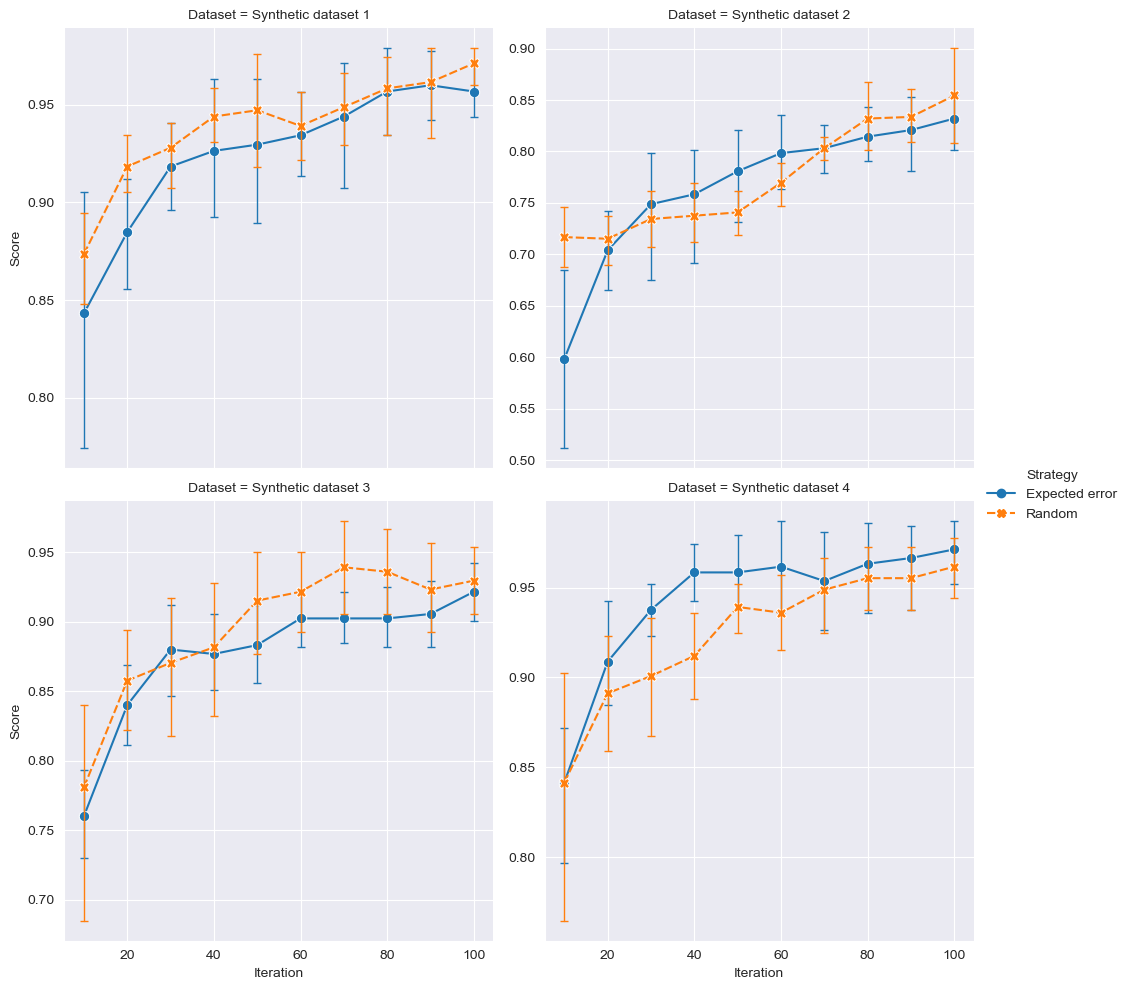

In [34]:
query_strategies = [
    expected_error_reduction,
    random_sampling
]

qs_names = [
    'Expected error',
    'Random'
]

col_iteration, col_score, col_dataset, col_strategy = run_experiment(query_strategies, qs_names)

df = pd.DataFrame({
    'Iteration' : np.array(col_iteration).flatten(), 
    'Score' : np.array(col_score).flatten(),
    'Dataset' : np.array(col_dataset).flatten(),
    'Strategy' : np.array(col_strategy).flatten()
})

plot_exp(df)

# Old code

fig, axs = plt.subplots(2, 2)

xs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

n = len(qs_names)

for i in range(n):
    axs[0,0].plot(xs, scores[i], label=qs_names[i])
    axs[0,0].set_title('Synthetic dataset 1')
    axs[0,0].legend()
    axs[0,0].grid()
    
for i in range(n):
    axs[0,1].plot(xs, scores[i+n], label=qs_names[i])
    axs[0,1].set_title('Synthetic dataset 2')
    axs[0,1].legend()
    axs[0,1].grid()

for i in range(n):
    axs[1,0].plot(xs, scores[i+2*n], label=qs_names[i])
    axs[1,0].set_title('Synthetic dataset 3')
    axs[1,0].legend()
    axs[1,0].grid()

for i in range(n):
    axs[1,1].plot(xs, scores[i+3*n], label=qs_names[i])
    axs[1,1].set_title('Synthetic dataset 4')
    axs[1,1].legend()
    axs[1,1].grid()


for ax in axs.flat:
    ax.set(xlabel='Iteration', ylabel='Test error')

fig.tight_layout()



plt.show()